# Tasca 06

Este ejercicio lo dividiremos en tres partes: 

1. Importación, descripción y preprocesamiento del dataset: 

2. Regresiones con dataset sin preprocesar, preprocesado y preprocesado sin la columna 'RM':

3. Hiperparámetros y cross-validation


El objetivo principal de este ejercicio es comparar los resultados de diferentes tipos de regresiones y determinar si existen diferencias significativas según se apliquen estas en dataset preprocesados y sin preprocesar. 

Además, determinaremos si a través de la utilización de hiperparámetros podemos mejorar los resultados de ciertos tipos de regresiones. 

In [1]:
# importamos las librerías necesarias para este ejercicio
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## Importación, descripción y preprocesamiento del dataset

### Importación del dataset

In [2]:
#creamos un objeto con los nombres de las columnas
col_names = (["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"])    

#importamos el data set con la función pd.read_csv
df =  pd.read_csv("housing data.csv", sep=",", names=col_names, engine="python")

### Descripción del dataset

In [3]:
#echamos un primer vistazo al dataset con el método head
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- Podemos observar un dataset compuesto exclusivamente por columnas númericas (dos de ellas int). 
- A primera vista notamos que las escalas de cada una de las columnas son diferentes.
- La columna "Chas" es binaria (0 y 1) y  la columna "RAD" está organizada por clases. 
- Por los datos añadidos en el archivo .txt podemos afirmar que la variable dependiente está contenida en la columna "MEDV" (Median value of owner-occupied homes in $1000's). 

Es decir que a través de las variables dependientes contenidas en el dataset intentaremos predecir el valor medio de las casas ocupadas por sus propietarios en miles de dólares. 

In [4]:
#confirmamos los types de las columnas mediante el método info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
#revisamos las dimensiones del dataset
df.shape

print("El dataset tiene {} observaciones y {} columnas".format(df.shape[0], df.shape[1]))

El dataset tiene 506 observaciones y 14 columnas


In [6]:
#realizamos una descripción estadística básica del data set con el metodo describe
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


A través del describe podemos observar que hay varias columnas que presentan un skew hacia la derecha. Por ejemplo "CRIM" y "ZN" presentan una gran diferencia entre su quartil 75% y el valor máximo. Esto nos da a entender que la distribución de sus datos no es normal. Por otra parte, columnas como "B" tienen la distribución contraria: un skew hacia la izquierda que puede comprobarse viendo que la mayoría de sus datos está agrupado en los cuartiles 25 - 100. 

Haremos ahora una presentación gráfica de los datos para comprobar nuestras observaciones

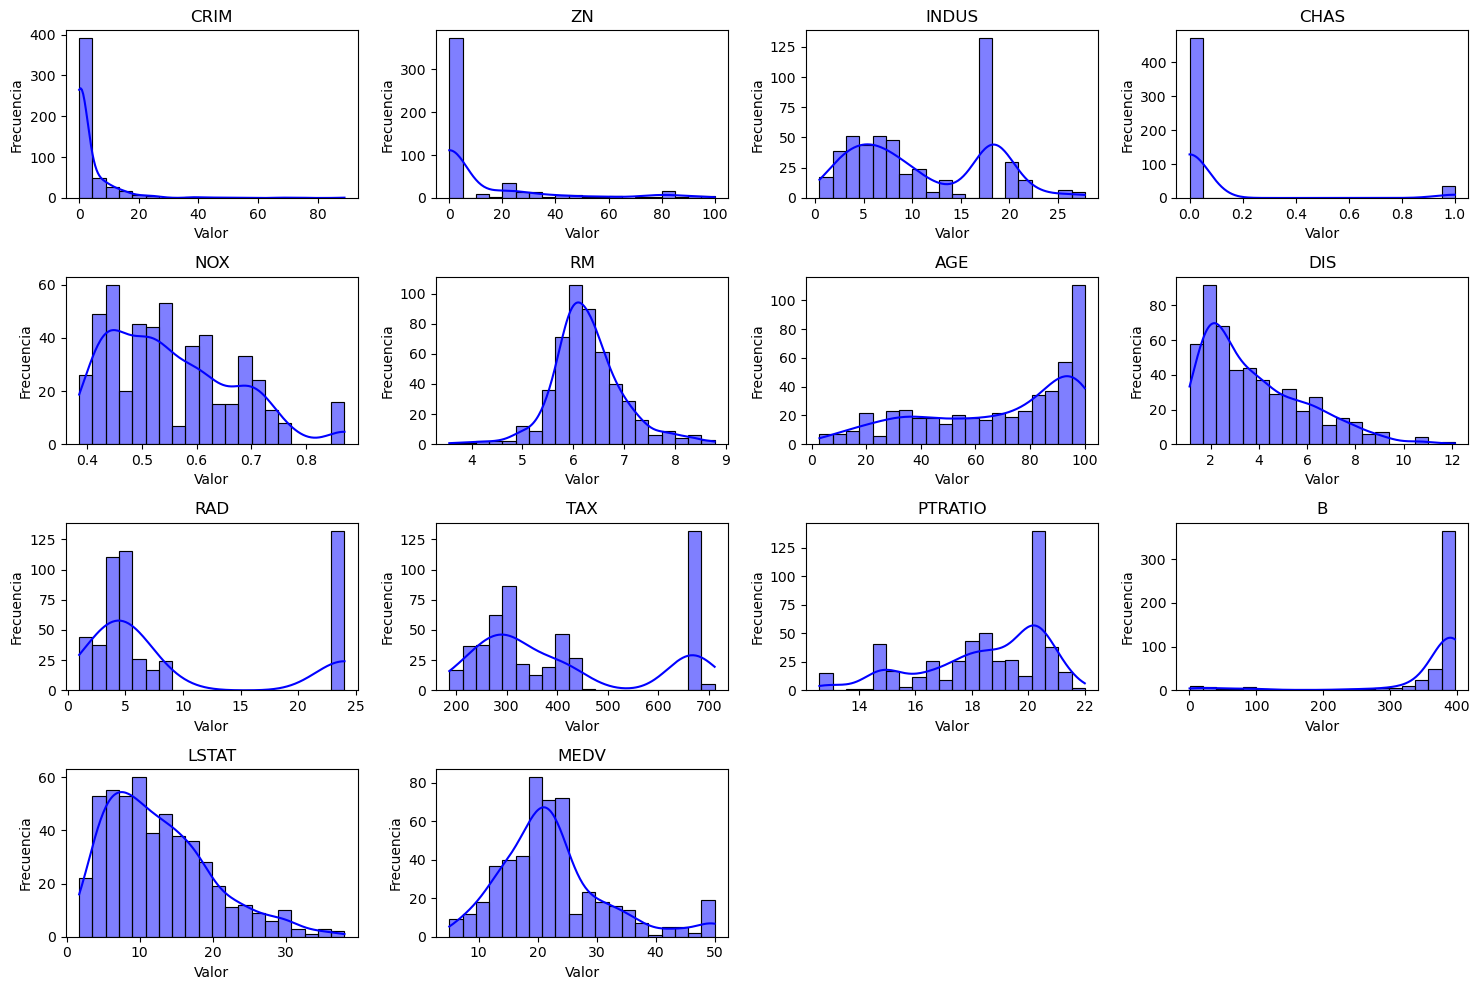

In [7]:
#creamos la figura
plt.figure(figsize=(15, 10))

#iteramos sobre cada columna en X_train y creamos un histograma
for i, column in enumerate(df.columns):
    plt.subplot(4, 4, i + 1) 
    sns.histplot(df[column], bins=20, kde=True, color='blue', edgecolor='black')
    plt.title(column)
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Con los histogramas podemos comprobar que columnas como "CRIM", "ZN", y "DIS" se escoran hacia la derecha, mientras que "AGE", "B", "PTRATIO" se escoran hacia la izquierda. Observamos distribuciones normales en la variable dependiente "MEDV", y en la columna "RM".

Dividiremos el data set entre las variables independientes (X) y la variable dependiente (y) para analizar que tanto peso tiene cada una de las variables en la posibilidad de predecir y. 

In [8]:
#separamos del dataset original las variables dependientes y las independientes
X = df.drop("MEDV", axis = 1)
y = df["MEDV"]

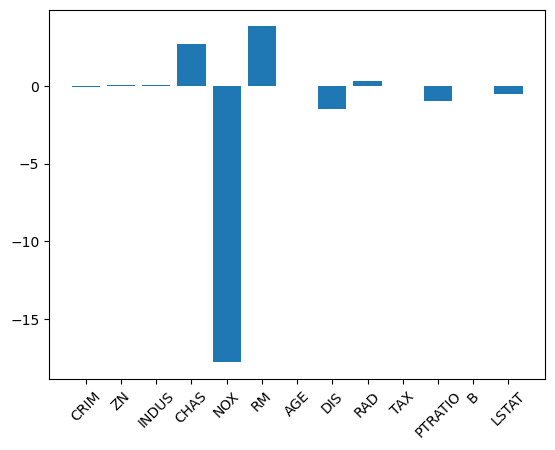

In [9]:
# calculamos los coeficientes de las variables independientes a partir de una regresión lineal básica

#instanciamos la función
lm = LinearRegression()

# entrenamos el modelo
lm.fit(X, y)

# calculamos el slope 
lm.coef_

#graficamos
names = X.columns

plt.bar(names, lm.coef_)
plt.xticks(rotation=45)
plt.show()

De la gráfica podemos concluir que los mayores pesos positivos frente a la variable dependiente los tienen las columnas "CHAS" y "RM". Es lógico pensar que una vivienda cueste más en función de su número de habitaciones y de su cercanía a un rio. Por el contrario, la variable que hace que más disminuya el precio de la vivienda es "NOX". De nuevo, parece lógico pensar que a mayor concentración de óxidos nítricos el valor de la vivienda disminuya. 

Finalmente, dibujaremos un heatmat para comprobar las correlaciones entre las variables independientes y la dependiente.


<Axes: >

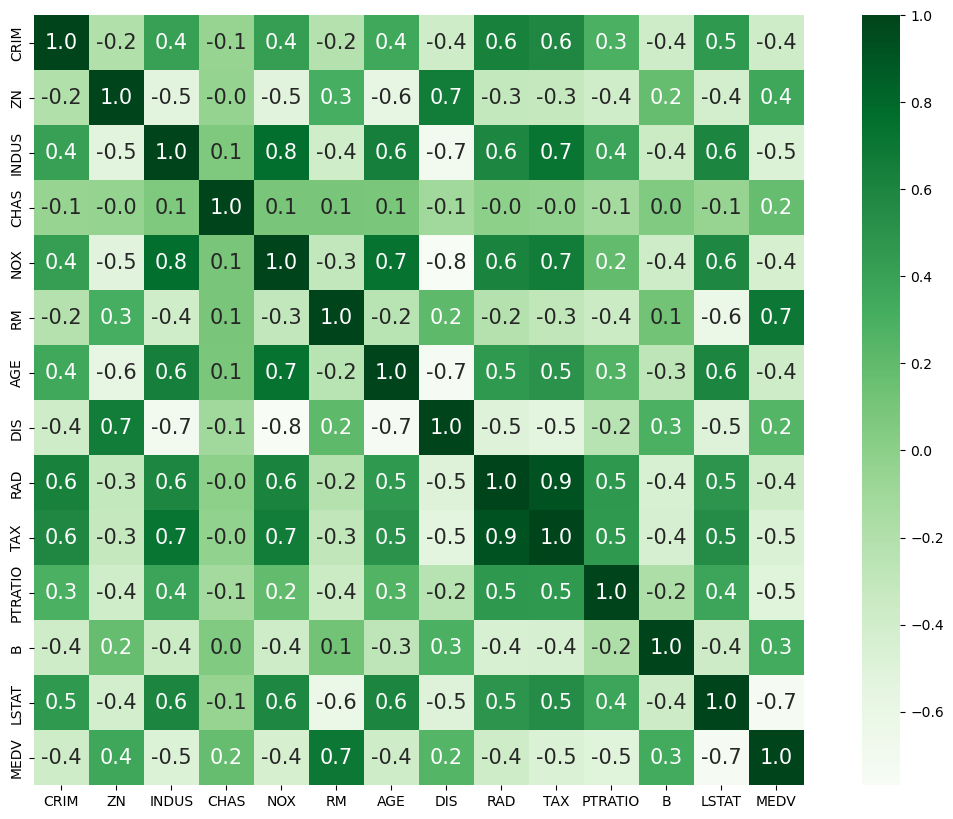

In [10]:
# calculamos los coeficientes de correlación
corr = df.corr()

# dibujamos el heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

A través del heatmap podemos concluir: 
    - la mayor parte de variables tienen una correlación negativa con la variable dependiente
    - "RM" es la variable que mayor coeficiente positivo tiene respecto de y 
    - "LSTAT" es la variable que mayor coeficiente negativo tiene respecto de y
    
Como podemos observar el análisis de correlación presenta unos resultados diferentes a los que obtuvimos del coeficiente de cada variable en la regresión multilineal. Esto tiene que ver con que la correlación entre las variables independientes y la dependiente es un método diferente a la regresión. Por ejemplo, en la correlación se evaluan la relación entre x y y de manera asilada mientras que la regresión es aditiva: los coeficientes (slopes) de las variables independientes se suman para establecer su relación con y. 

Después de haber descrito nuestro dataset y de entender un poco la relación entre sus variables vamos a transformar algunas columnas para que se ajusten mejor a los modelos de ML. 

### Preprocesamiento del dataset

Según la descripción del dataset realizaremos dos tipos distintos de preprocesado: 
- Transformaremos las columnas númericas mediante un RobustScaler teniendo en cuenta que los outliers que detectamos en la descripción. 
- Las columnas categoricas las transformaremos en dummies. 

De cara al objetivo de este ejercicio produciremos tres dataset: 
- Uno si ningún tipo de transformación. 
- Uno preprocesado con todas las columnas.
- Uno preprocesado sin la columna "RM". 

In [11]:

# Train-Test Split sin preprocesamiento
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train-Test Split con preprocesamiento usando RobustScaler y Dummies
numeric_features = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
categorical_features = ['CHAS', 'RAD'] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# ajustamos el pipeline con las transformaciones al conjunto de variables independientes 
X_preprocessed = pipeline.fit_transform(X)
X_train_preprocessed, X_test_preprocessed, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Train-Test Split con preprocesamiento sin la columna 'RM'
numeric_features_without_RM = ['CRIM', 'ZN', 'INDUS', 'NOX', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT']
preprocessor_without_RM = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features_without_RM),
        ('cat', OneHotEncoder(), categorical_features)
    ])

pipeline_without_RM = Pipeline(steps=[('preprocessor', preprocessor_without_RM)])

# ajustamos el pipeline con las transformaciones al conjunto de variables independientes (sin RM)
X_preprocessed_without_RM = pipeline_without_RM.fit_transform(df.drop(['MEDV', 'RM'], axis=1))
X_train_preprocessed_without_RM, X_test_preprocessed_without_RM, y_train, y_test = train_test_split(X_preprocessed_without_RM, y, test_size=0.2, random_state=42)

## Ejecución y comparación de modelos 

En esta sección utilizaremos cuatro modelos de ML que aplicaremos a los tres datasets que hemos creado. Los modelos son: 
- Regresión linear multivariable: es un tipo de regresión en el que intentamos predecir una variable depediente (y) a través de dos o más variables independientes (X) utilizando un coeficiente que indica la fuerza de cada variable dentro de la predicción (slope) y un coeficiente constante que indica el valor mínimo de y (intercept) 
- Random Forrest: es un tipo de regresión que combina múltiples árboles de decisión para crear un modelo más robusto y preciso,utilizando técnicas de promediado y muestreo aleatorio para mejorar la generalización y reducir el sobreajuste.
- XGBoost Regressor: es un modelo que utiliza el algoritmo Gradient Boosting para combinar muchos árboles de decisión, en un modelo más potente y preciso. También incorpora técnicas como regularización y control de la complejidad del modelo para mejorar su rendimiento y capacidad de generalización. 
- SVM Regressor: es un tipo de algoritmo que encuentra una línea o superficie que separa diferentes grupos de datos de la mejor manera posible. Esto se hace al encontrar los puntos más importantes, llamados "vectores de soporte", y maximizar el espacio entre ellos.


Los utilizaremos es su forma básica (es decir, no los ajustaremos con hiperparámetros) para luego escoger los que mejores puntajes obtengan y sobre ellos emplear GridSearch y Cross-Validation (es decir, lograr definir los hiperparámetros más adecuados para mejorar el modelo y realizar una validación cruzada). 

### 1. Modelos con el data set sin preprocesar

In [16]:
# creamos los modelos (este paso lo realizaremos solo una vez pues utilizaremos los mismos modelos para los 3 datasets)

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost Regressor': XGBRegressor(),
    'SVM Regressor': svm.SVR()
}

# entrenamos y evaluamos los modelos (el entrenamiento se hace con el conjunto train y la evaluación con el conjunto test)
results_raw = {}
for model_name, model in models.items():
    model.fit(X_train_raw, y_train)
    y_pred_raw = model.predict(X_test_raw)
    r2 = metrics.r2_score(y_test, y_pred_raw)
    mse = metrics.mean_squared_error(y_test, y_pred_raw)
    results_raw[model_name] = (r2, mse)

# imprimimos los resultados
for model_name, (r2, mse) in results_raw.items():
    print(f'Model: {model_name}')
    print(f'r2: {r2:.3f}')
    print(f'mse: {mse:.3f}')
    print('-' * 50)

Model: Linear Regression
r2: 0.669
mse: 24.291
--------------------------------------------------
Model: Random Forest
r2: 0.879
mse: 8.861
--------------------------------------------------
Model: XGBoost Regressor
r2: 0.906
mse: 6.909
--------------------------------------------------
Model: SVM Regressor
r2: 0.279
mse: 52.838
--------------------------------------------------


La evaluación de los modelos nos permite concluir que corriéndolos sobre el conjunto de datos sin preprocesar el que tiene mayor capacidad predictiva es el XGBoost Regressor, seguido del Random Forest. Podríamos pensar que los modelos de árbol de decisión son lo que más le convienen a nuestro conjunto de datos. 

### 2. Modelos con el dataset completo preprocesado

In [17]:
# entrenamos y evaluamos los modelos 
results_preprocessed = {}
for model_name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred_preprocessed = model.predict(X_test_preprocessed)
    r2 = metrics.r2_score(y_test, y_pred_preprocessed)
    mse = metrics.mean_squared_error(y_test, y_pred_preprocessed)
    results_preprocessed[model_name] = (r2, mse)

# imprimimos los resultados
for model_name, (r2, mse) in results_preprocessed.items():
    print(f'Model: {model_name}')
    print(f'r2: {r2:.3f}')
    print(f'mse: {mse:.3f}')
    print('-' * 50)

Model: Linear Regression
r2: 0.662
mse: 24.818
--------------------------------------------------
Model: Random Forest
r2: 0.888
mse: 8.237
--------------------------------------------------
Model: XGBoost Regressor
r2: 0.908
mse: 6.767
--------------------------------------------------
Model: SVM Regressor
r2: 0.531
mse: 34.393
--------------------------------------------------


Con el conjunto de datos preprocesado podemos observar que el modelo mayor beneficiado es el SVM cuyo r2 sube de 0.28 a 0.53, sin embargo sigue presentando las peores calificaciones. Es notable también que el r2 se la regresión lineal haya bajado pasando de 0.67 a 0.66. Random Forest y XGBoost se mantienen como lo modelos que reciben mejor calificación. 

### 3. Modelos con el dataset preprocesado sin la columna 'RM'

In [18]:
# entrenamos y evaluamos los modelos 
results_without_RM = {}
for model_name, model in models.items():
    model.fit(X_train_preprocessed_without_RM, y_train)
    y_pred_preprocessed_without_RM = model.predict(X_test_preprocessed_without_RM)
    r2 = metrics.r2_score(y_test, y_pred_preprocessed_without_RM)
    mse = metrics.mean_squared_error(y_test, y_pred_preprocessed_without_RM)
    results_preprocessed[model_name] = (r2, mse)

# imprimimos los resultados
for model_name, (r2, mse) in results_preprocessed.items():
    print(f'Model: {model_name}')
    print(f'r2: {r2:.3f}')
    print(f'mse: {mse:.3f}')
    print('-' * 50)

Model: Linear Regression
r2: 0.687
mse: 22.965
--------------------------------------------------
Model: Random Forest
r2: 0.815
mse: 13.556
--------------------------------------------------
Model: XGBoost Regressor
r2: 0.835
mse: 12.081
--------------------------------------------------
Model: SVM Regressor
r2: 0.446
mse: 40.630
--------------------------------------------------


Como vimos en la descripción del dataset la variable RM tenía tanto el coeficiente de correlación como el slope más altos respecto de la variable dependiente. Repetimos que es lógico que a mayor número de habitaciones el precio de una vivienda aumente. Por esta razón, no es sorprendente que los scores de todos los modelos bajen más o menos de la misma manera, aunque haya que resaltar que la regresión lineal es la que se ve menos afectada. 

Para concluir, según los resultados de los tres análisis anteriores podemos afirmar que los modelos que presentan mejores resultados son Random Forest y XGBoost Regressor, por esa razón los seleccionaremos para la siguiente fase: utilización de hiperparámetros y validación cruzada. Añado que estos análisis los haremos con los modelos escogidos utilizando el conjunto completo de datos preprocesados. 

## Hiperparámetros y cross-validation

En esta sección combinaremos GridSearch y cross-validation para ajustar al máximo los modelos que escogimos anteriormente. 

Cross-Validation es un tipo específico de evaluación que maximiza la cantidad de datos disponibles para el modelo utilizando diferentes splits y folds (escoge de manera aleatoria conjuntos de datos para entrenar el modelo y repite dicha escogencia el número de veces que le digamos). 

Los hiperparámetros son ajustes específicos a cada modelo que permiten que su capacidad de predicción mejore (por ejemplo, podemos escoger el número de árboles que hacen parte de un random forest). En esta ocasión utilizaremos un GridSearch que, después de probar con diferentes combinaciones, nos indica que conjunto de hiperparámetros es mejor para un modelo determinado maximizando el rendimiento del modelo. 

### Random Forest 

In [15]:
#definimos los pliegues (el número de iteraciones)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

#instanciamos el modelo
rf = RandomForestRegressor(random_state=42)

#definimos los rangos de cada hiperparámetro en un diccionario
param_grid =  {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#corremos el GridSearch utilizando como argumentos el modelo, los parámetros y el KFold y lo convertimos en un objeto
rf_cv = GridSearchCV(rf, param_grid, cv=kf)

#ajustamos el modelo  a partir del objeto que creamos con el GridSearch
rf_cv.fit(X_train_preprocessed, y_train)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [19]:
#imprimimos la selección de los mejores hiperparámetros 
print('Los mejores hiperparámetros son: {}'.format(rf_cv.best_params_))

Los mejores hiperparámetros son: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [22]:
# evaluamos el modelo utilizando los datos test empleando el mejor modelo entrenado
best_rf_model = rf_cv.best_estimator_

y_pred_preprocessed = best_rf_model.predict(X_test_preprocessed)

r2 = metrics.r2_score(y_test, y_pred_preprocessed)
print(f'El r2 del random forest con los parámetros señalados por el GridSearch, es de {r2:.3f}')

El r2 del random forest con los parámetros señalados por el GridSearch, es de 0.865


In [23]:
#comprobaremos los resultados del modelo anterior corriendo un random forest con los parámetros escogidos por el GridSearch

rf_best = RandomForestRegressor(
    n_estimators=200,
    max_features='sqrt',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    random_state=42
)

#entrenamos el modelo
rf_best.fit(X_train_preprocessed, y_train)

#realizamos predicciones con el conjunto de prueba
y_pred_best = rf_best.predict(X_test_preprocessed)

#calculamos el r2
r2 = metrics.r2_score(y_test, y_pred_best)
print(f'El r2 del modelo sobre el conjunto de prueba es de {r2:.3f}')

El r2 del modelo sobre el conjunto de prueba es de 0.865


Al comparar el r2 de los modelos podemos observar que, al contrario de lo pensado, aquel en el cual empleamos hiperparámetros es más bajo que el modelo en el que no los usamos (0.865 con hiperparámetros y 0.888 sin hiperparámetros). Aquí tenemos que aclarar que la utilización de los hiperpárametros no tiene como objetivo simplemente mejorar el resultado cuantitativo del modelo sino que pretende mejorar la generalización del modelo a nuevos datos, incluso si esto significa un puntaje un poco menor. 

Utilizemos ahora los hiperparámetros con el XGBoost para determinar como se comportan sus resultados

### XGBoost

Por limitaciones de capacidad computacional con el XGBoost utilizaremos solo un GridSearch con cuatro hiperamétros. La validación cruzada no la realizaremos con el KFold sino que la incluiremos como un argumento dentro del GridSearch. 

In [24]:
#instanciamos el modelo
xgb = XGBRegressor (random_state=42)

#construimos un diccionario con los hiperparámetros 
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3]
}

#inicializamos el objeto GridSearchCV incluyendo 3 pliegues y un nivel 2 de verbosidad para poder leer el proceso
#de análisis
xgb_best = GridSearchCV(xgb, param_grid=param_grid, cv=3, verbose=2) 

#entrenamos el modelo 
xgb_best.fit(X_train_preprocessed, y_train)

#imprimimos los mejores parámetros encontrados
print("Los mejores hiperparámetros son:", xgb_best.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_c

[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_ra

[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100; total time=   0.1s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.2s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=200; total time=   0.3s
[CV] END learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=300; total time=   0.5s
[CV] END learning_ra

In [29]:
# evaluamos el modelo utilizando los datos test empleando el mejor modelo entrenado
best_xgb_model = xgb_best.best_estimator_

y_pred_preprocessed = best_xgb_model.predict(X_test_preprocessed)

r2 = metrics.r2_score(y_test, y_pred_preprocessed)
print(f'El r2 del random forest con los parámetros señalados por el GridSearch, es de {r2:.3f}')

El r2 del random forest con los parámetros señalados por el GridSearch, es de 0.922


In [30]:
#comprobaremos los resultados del modelo anterior corriendo xgboost con los parámetros escogidos por el GridSearch

xgb_best = XGBRegressor(
    learning_rate= 0.1, 
    max_depth= 3, 
    min_child_weight= 1, 
    n_estimators= 300,
    random_state=42
)

#entrenamos el modelo
xgb_best.fit(X_train_preprocessed, y_train)

#realizamos predicciones con el conjunto de prueba
y_pred_best = xgb_best.predict(X_test_preprocessed)

#calculamos el r2
r2 = metrics.r2_score(y_test, y_pred_best)
print(f'El r2 del modelo sobre el conjunto de prueba es de {r2:.3f}')

El r2 del modelo sobre el conjunto de prueba es de 0.922


En el caso del XGBoost los hiperparámetros si que modificaron positivamente el r2 del modelo pasando de un 0.908 sin ellos a un 0.922 con ellos. 

Esta última conclusión nos permite afirmar que el mejor modelo para analizar nuestro conjuntos de datos completo preprocesado es XGBRegressor con los siguientes hiperparámetros: learning_rate= 0.1, max_depth= 3, min_child_weight= 1, n_estimators= 300, random_state=42

## Conclusiones finales: 

- los modelos más complejos (random forest y XGBoost) son los que más se acomodan a las características de nuestro data set.
- El peso de la columna 'RM' es tal que su eliminación del dataset hace que las evaluaciones de todos los modelos empeoren. 
- De manera lógica las columnas que más peso positivo tienen a la hora de pronosticar el precio de una vivienda son su número de habitaciones y su cercanía con el río. 
- Por el contrario, el peso negativo de la columna 'NOX' es evidente -a más contaminación, menos precio- pero puede que esté sobrerpresentado. 